# Responses API

The Responses API provides a structured response format that allows AI to interact with multiple tools while maintaining context across interactions. It supports: 

- **Tool calling in one simple API call**: Now, developers can seamlessly integrate AI tools, making execution more efficient. 
- **Computer use**: Use the computer use tool within the Responses API to drive automation and execute software interactions. 
- **File search**: Interact with enterprise data dynamically and extract relevant information. 
- **Function calling**: Develop and invoke custom functions to enhance AI capabilities. 
- **Chaining responses into conversations**: Keep track of interactions by linking responses together using unique response IDs, ensuring continuity in AI-driven dialogues. 
- **Enterprise-grade data privacy**: Built with Azure’s trusted security and compliance standards, ensuring data protection for organizations
  
> https://azure.microsoft.com/en-us/blog/announcing-the-responses-api-and-computer-using-agent-in-azure-ai-foundry/?msockid=2e39c66c693c66a5151fd200687567d0

In [1]:
import base64
import json
import os
import random
import requests
import sys

from dotenv import load_dotenv
from datetime import datetime
from openai import AzureOpenAI
from PIL import Image

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
print(f"Today is {datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 18-Apr-2025 07:29:07


# Client

In [4]:
load_dotenv("azure.env")

True

In [5]:
client = AzureOpenAI(
    api_key = os.environ["AZURE_OPENAI_API_KEY"],  
    api_version = os.environ["AZURE_OPENAI_API_VERSION"],
    azure_endpoint = os.environ["AZURE_OPENAI_API_ENDPOINT"]
)

## Quick test

In [6]:
prompt = "Hello"

response = client.responses.create(
    model=os.environ["AZURE_OPENAI_API_MODEL"],
    input=prompt,
    #truncation="auto" required when using computer-use-preview model.
)

In [7]:
response

Response(id='resp_6801ff43aa78819084080eb7db65aa63', created_at=1744961347.0, error=None, incomplete_details=None, instructions=None, metadata={}, model='gpt-4o-mini', object='response', output=[ResponseOutputMessage(id='msg_6801ff43edd08190a1cab0066bd8708e', content=[ResponseOutputText(annotations=[], text='Hello! How can I assist you today?', type='output_text')], role='assistant', status='completed', type='message')], parallel_tool_calls=True, temperature=1.0, tool_choice='auto', tools=[], top_p=1.0, max_output_tokens=None, previous_response_id=None, reasoning=Reasoning(effort=None, generate_summary=None), status='completed', text=ResponseTextConfig(format=ResponseFormatText(type='text')), truncation='disabled', usage=ResponseUsage(input_tokens=25, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=11, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=36), user=None, store=True)

In [8]:
print(response.output_text)

Hello! How can I assist you today?


## Chaining response

In [9]:
previous_response_id = None

while True:
    user_input = input("Enter your message (or type 'exit' to quit): ").strip()
    
    if user_input.lower() == "exit":
        break

    params = {
        "model": os.environ["AZURE_OPENAI_API_MODEL"],
        "input": [{"role": "user", "content": user_input}],
        "stream": True
    }
    
    if previous_response_id:
        params["previous_response_id"] = previous_response_id

    stream = client.responses.create(**params)

    for event in stream:
        if event.type == 'response.created':
            previous_response_id = event.response.id

        if event.type == 'response.output_text.delta':
            print(event.delta, end='')

    print()

Enter your message (or type 'exit' to quit):  hello


Hello! How can I assist you today?


Enter your message (or type 'exit' to quit):  who are you?


I'm an AI developed to assist and provide information on a wide range of topics. How can I help you today?


Enter your message (or type 'exit' to quit):  exit


## Function calling

In [10]:
def get_weather(latitude, longitude):
    """
    Fetches the current temperature for a given latitude and longitude using the Open-Meteo API.

    Parameters:
    latitude (float): The latitude of the location.
    longitude (float): The longitude of the location.

    Returns:
    float: The current temperature in degrees Celsius at the specified location.
    """
    response = requests.get(f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current=temperature_2m,wind_speed_10m&hourly=temperature_2m,relative_humidity_2m,wind_speed_10m")
       
    return response.json()['current']['temperature_2m']

In [11]:
tools = [{
    "type": "function",
    "name": "get_weather",
    "description": "Get current temperature for provided coordinates in celsius.",
    "parameters": {
        "type": "object",
        "properties": {
            "latitude": {"type": "number"},
            "longitude": {"type": "number"}
        },
        "required": ["latitude", "longitude"],
        "additionalProperties": False
    },
    "strict": True
}]


In [12]:
prompt = "What's the weather like in Paris today?"

In [13]:
input_messages = [{"role": "user", "content": prompt }]

response = client.responses.create(
    model=os.environ["AZURE_OPENAI_API_MODEL"],
    input=input_messages,
    tools=tools,
)

tool_call = response.output[0]
args = json.loads(tool_call.arguments)

result = get_weather(args["latitude"], args["longitude"])

In [14]:
args

{'latitude': 48.8566, 'longitude': 2.3522}

In [15]:
response.output[0]

ResponseFunctionToolCall(arguments='{"latitude":48.8566,"longitude":2.3522}', call_id='call_X1UICTkBsYV2sqktpgvNy7zX', name='get_weather', type='function_call', id='fc_6801ff5091848190a478d49dfcefc787', status='completed')

In [16]:
response

Response(id='resp_6801ff4fe43c81908f74a1919b9267b2', created_at=1744961359.0, error=None, incomplete_details=None, instructions=None, metadata={}, model='gpt-4o-mini', object='response', output=[ResponseFunctionToolCall(arguments='{"latitude":48.8566,"longitude":2.3522}', call_id='call_X1UICTkBsYV2sqktpgvNy7zX', name='get_weather', type='function_call', id='fc_6801ff5091848190a478d49dfcefc787', status='completed')], parallel_tool_calls=True, temperature=1.0, tool_choice='auto', tools=[FunctionTool(name='get_weather', parameters={'type': 'object', 'properties': {'latitude': {'type': 'number'}, 'longitude': {'type': 'number'}}, 'required': ['latitude', 'longitude'], 'additionalProperties': False}, strict=True, type='function', description='Get current temperature for provided coordinates in celsius.')], top_p=1.0, max_output_tokens=None, previous_response_id=None, reasoning=Reasoning(effort=None, generate_summary=None), status='completed', text=ResponseTextConfig(format=ResponseFormatTex

In [17]:
result

8.5

In [18]:
input_messages.append(tool_call)

input_messages.append({                              
    "type": "function_call_output",
    "call_id": tool_call.call_id,
    "output": str(result)
})


response_2 = client.responses.create(
    model=os.environ["AZURE_OPENAI_API_MODEL"],
    input=input_messages,
    tools=tools,
)

print(response_2.output_text)

The temperature in Paris today is 8.5°C. If you need more details about the weather, let me know!


## Image analysis

In [19]:
image_file = "image.png"

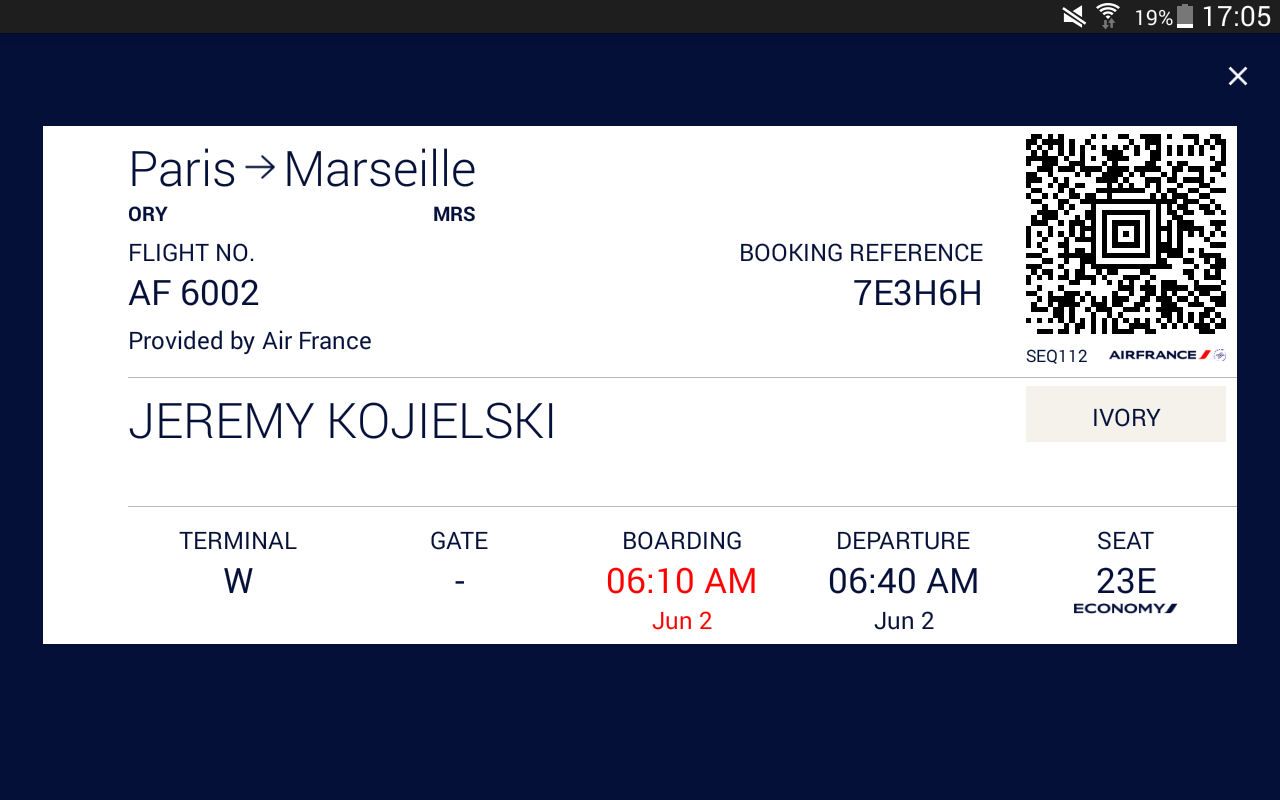

In [20]:
img = Image.open(image_file)
img

In [21]:
def encode_image(image_file):
    """
    Encodes an image file to a base64 string.

    Args:
        image_path (str): The path to the image file to be encoded.

    Returns:
        str: The base64 encoded string of the image.
    """
    with open(image_file, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [22]:
def image_analysis(image_file, prompt):
    """
    Sends an image and a prompt to the Azure OpenAI API and prints the response.

    Args:
        image_file (str): The path to the image file to be sent.
        prompt (str): The prompt to be sent along with the image.

    Returns:
        None: The function prints the response from the API.
    """
    base64_image = encode_image(image_file)
    
    response = client.responses.create(
        model=os.environ["AZURE_OPENAI_API_MODEL"],
        input=[
            {"role": "user", "content": prompt},
            {"role": "user", "content": [
                {
                    "type": "input_image",
                    "image_url": f"data:image/png;base64,{base64_image}"
                }
            ]
        }
    ]
    )
    
    return response.output_text

In [23]:
image_analysis(image_file, "What is it?")

'This is a flight boarding pass for a flight from Paris (ORY) to Marseille (MRS) on Air France. The details include the flight number (AF 6002), passenger name (JEREMY KOJIELSKI), booking reference, terminal (W), boarding time (06:10 AM on June 2), departure time (06:40 AM on June 2), and seat number (23E) in economy class.'

In [24]:
image_analysis(image_file, "What is the booking reference?")

'The booking reference is **7E3H6H**.'

In [25]:
result = image_analysis(image_file, "What is airplane company and what can you tell about it?")
print(result)

The airline company mentioned in your image is **Air France**. It is the national flag carrier of France and is one of the largest airlines in Europe. 

### Key Information:
- **Founded:** 1933
- **Headquarters:** Paris, France
- **Hub:** Charles de Gaulle Airport
- **Fleet:** A diverse range of aircraft including short, medium, and long-haul options.
- **Services:** Offers passenger and cargo transport, with a strong focus on comfort and quality service.
- **Membership:** Part of the SkyTeam airline alliance, which allows for a broader network and benefits for travelers.

Air France operates both domestic and international flights, providing services to many destinations worldwide.


## File search

In [26]:
!wget https://arxiv.org/pdf/2311.06242 -O document.pdf

--2025-04-18 07:29:31--  https://arxiv.org/pdf/2311.06242
Resolving arxiv.org (arxiv.org)... 151.101.67.42, 151.101.3.42, 151.101.131.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.67.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56176792 (54M) [application/pdf]
Saving to: ‘document.pdf’

document.pdf        100%[===================>]  53.57M  32.2MB/s    in 1.7s    

2025-04-18 07:29:33 (32.2 MB/s) - ‘document.pdf’ saved [56176792/56176792]



In [27]:
!ls document.pdf -lh

-rwxrwxrwx 1 root root 54M Apr 18 07:29 document.pdf


In [28]:
index_name = f"book_{str(random.randint(0, 100000))}"

document = "document.pdf"

In [29]:
# Create a vector store in Azure OpenAI
vector_store = client.vector_stores.create(name=index_name)

In [30]:
# Ready the files for upload to Azure OpenAI
file_paths = [document]
file_streams = [open(path, "rb") for path in file_paths]

# Use the upload and poll SDK helper to upload the files, add them to the vector store,
# and poll the status of the file batch for completion.
file_batch = client.vector_stores.file_batches.upload_and_poll(
    vector_store_id=vector_store.id, files=file_streams
)

In [31]:
print(file_batch.status.upper())
print(file_batch.file_counts)
print("Vector Store ID:",vector_store.id)

COMPLETED
FileCounts(cancelled=0, completed=1, failed=0, in_progress=0, total=1)
Vector Store ID: vs_IO2xhKHxgWOragAuJEfYAdNw


### Vector stores
<img src="vector.jpg">

In [32]:
def file_search(prompt):
    response = client.responses.create(
        model=os.environ["AZURE_OPENAI_API_MODEL"],
        tools=[{
          "type": "file_search",
          "vector_store_ids": [vector_store.id],
          "max_num_results": 20
        }],
        input=prompt,
    )

    return response.output_text

In [33]:
result = file_search("Summarize this document")
print("\033[1;31;34m")
print(result)


The document details the development of the Florence-2 model, a sophisticated foundation model for computer vision that integrates various visual tasks using a unified architecture. Key points include:

1. **Data Generation**: The model relies on a large-scale dataset called FLD-5B, which includes 126 million images accompanied by 5.4 billion annotations. This dataset is generated primarily by specialist models rather than labor-intensive manual annotations, ensuring high-quality and comprehensive data.

2. **Annotation Process**: The initial annotations are created using a combination of synthetic labels from specialist models and pre-existing human annotations. This process may exclude certain tasks initially due to the scarcity of data, with an iterative refinement phase to improve annotation quality over time.

3. **Model Architecture**: The Florence-2 employs a sequence-to-sequence (seq2seq) learning paradigm, integrating visual and textual data for various tasks, such as caption

In [34]:
result = file_search("Do we have some 'fine tuning' mentions in this document?")
print("\033[1;31;34m")
print(result)


Yes, the document contains multiple mentions of "fine-tuning." Here are some key excerpts:

1. **Generalist Model with Public Supervised Data**: The model demonstrates its adaptability by fine-tuning Florence-2 models using a collection of public datasets to cover different tasks, establishing state-of-the-art performance.

2. **Downstream Tasks Fine-tuning**: The document specifically investigates the performance of the single model after fine-tuning for various downstream tasks.

3. **High-level Methodology**: It highlights the efficacy of pre-training followed by fine-tuning, showcasing improved performance over larger models even with a compact architecture.

If you need further details or specific sections, feel free to ask!


In [35]:
result = file_search("Do we have some benchmarks informations?")
print("\033[1;31;34m")
print(result)


Here are key pieces of benchmarking information extracted from the document:

1. **Model Performance**:
   - The performance of the **Florence-2-L model** achieved a **CIDEr score of 135.6** on the COCO caption benchmark with only **0.77 billion parameters**, outperforming the **Flamingo model** (80B parameters) which scored 138.1.

2. **Zero-shot Evaluation**:
   - The **Florence-2** model established new state-of-the-art zero-shot performance across various tasks including:
     - **Captioning on COCO**
     - **Visual grounding on Flick30k**
     - **Referring expression comprehension on RefCOCO/+/g**.

3. **Training Efficiency**:
   - Efficient training schedules were indicated with the **DINO framework**, which demonstrated improvements of up to **4x efficiency** in comparison to existing methods on tasks like COCO detection and ADE20K semantic segmentation.

4. **Specialist vs. Generalist Models**:
   - Specialist models were fine-tuned for specific tasks showing high performanc

In [36]:
result = file_search("What are the number of parameters of Florence-2")
print("\033[1;31;34m")
print(result)


The Florence-2 model has two variants with different numbers of parameters:

- **Florence-2-B**: 232 million parameters
- **Florence-2-L**: 771 million parameters.


### Delete the vector store

In [37]:
client.vector_stores.delete(vector_store_id=vector_store.id)

VectorStoreDeleted(id='vs_IO2xhKHxgWOragAuJEfYAdNw', deleted=True, object='vector_store.deleted')